# Assignment for Week 8 - Reinforcement Learning

**Exercise**: Q-Learning

**Objective**: Reproduce the exercise explained in the following tutorial videos:

* https://www.youtube.com/watch?v=yMk_XtIEzH8&list=PLQVvvaa0QuDezJFIOU5wDdfy4e9vdnx-7
* https://www.youtube.com/watch?v=Gq1Azv_B4-4
* https://www.youtube.com/watch?v=CBTbifYx6a8

**NOTE**:   You don't need to reproduce all of the graphs demostrated in the
            third video for this assignment. Please include 2 of the
            demonstrated graphs.

## Bellman Equation

The source material (PythonProgramming.net, n.d) utilizes Equation 2b below
(and the author references the formula on Wikipedia, paraphrased with
Equation 2a).  However, Hayes (2019) utilizes Equation 1 below.  Provided below
is a simple exercise to reconcile the equations.

$$
\begin{align*}

\text{(1) } Q^{new}(S_t, A_t) &\leftarrow Q(S_t, A_t) + \alpha \cdot [ R_t + \gamma \cdot \max_a Q(S_{t+1}, a) - Q(S_t, A_t) ] \\

Q^{new}(S_t, A_t) &\leftarrow Q(S_t, A_t) + \alpha \cdot R_t + \alpha \cdot \gamma \cdot \max_a Q(S_{t+1}, a) - \alpha \cdot Q(S_t, A_t) \\

Q^{new}(S_t, A_t) &\leftarrow Q(S_t, A_t)  - \alpha \cdot Q(S_t, A_t) + \alpha \cdot R_t + \alpha \cdot \gamma \cdot \max_a Q(S_{t+1}, a) \\

\text{(2a) } Q^{new}(S_t, A_t) &\leftarrow \underbrace{ (1 - \alpha) \cdot Q(S_t, A_t)}_\text{weighted current value} + \underbrace { \alpha \cdot R_t }_\text{weighted reward} + \underbrace{ \alpha \cdot \gamma \cdot \max_a Q(S_{t+1}, a)}_\text{weighted maximum reward} \\

\text{(2b) } Q^{new}(S_t, A_t) &\leftarrow (1 - \alpha) \cdot Q(S_t, A_t) + \alpha \cdot [ R_t + \gamma \cdot \max_a Q(S_{t+1}, a) ] \\
\end{align*}
\\
\\
\begin{align*}
(1 - \alpha) \cdot Q(S_t, A_t) &= \text{current value, weighted by learning rate} \\
\alpha \cdot R_t &= \text{reward, weighted by learning rate} \\
\alpha \cdot \gamma \cdot \max_a Q(S_{t+1}, a) &= \text{max possible reward of state } S_{t+1} \text{ weighted by learning rate and discount} \\
\end{align*}
$$

# 1 Setup

## 1.A MountainCar Q-Learning Implementation

The `qmtncar.py` contains abstractions for calculating Q-Values as well as
managing a series of episodes.  In addition to executing the episodes, 
`qmtncar.py` saves the resulting metrics in a `csv` file after all episodes
are completed.

A brief description of each class is provided below.  See `qmtncar.py` for
complete source code

### 1.A.1 `Action` (Enum)

This enumaration provides meaningful named constants to replace the (less
intuitive) numerical values for accelerating left or right.

### 1.A.2 `State`

This class wraps the *continuous* and *discrete* values for a given state as
well as providing Python @property values for accessing position and velocity
(vice indexing numerically in a `tuple`)

* `State.observation` returns a tuple representing continuous values for
  position and velocity, respectively
* `State.binned` returns a tuple representing discrete values for position and
  velocity, respectively
* `State.position` returns the continuous value for position
* `State.velocity` returns the continuous value for velocity

### 1.A.3 `StateSpace`

Encapsulates the descretization of the continous state space of the environment

* `StateSpace.observation_state` returns a `State` object representing the
  given observation

### 1.A.4 `QTable`

Encapsulates the accumulated Q-Table for the simulation as well as the update
mechanism (via the Bellman equation) for the Q values.

* `QTable.select_action` returns an `Action` to execute from the given `state`.
  Based on `epsilon`', the returned `Action` will either exploit the accumulated
  learning (value) of the current state or will be exploratory (i.e. random)
* `QTable.update` updates the Q-Table at the given `current_state` based on
  the executed `action`, given `next_state`, and received `reward`.
  *`QTable.update` utilizes Equation 1 (above) for updating values*

### 1.A.5 `QMtnCar`

Manages the execution of episodes and steps within the Python environment for
`MountainCar-v0`.

* `QMtnCar.__enter__` and `QMtnCar.__exit__` methods which allow a `QMtnCar` to
  act as a context (which can automatically perform actions such as closing
  resources upon exit)
* `QMtnCar.run_episode` executes a single Python `gym` episode.  Interacts with
  `QTable` to select new actions and update values upon each iteration.
  Collects metrics in `QMtnCar.metrics_df` for each step.

## 1.B Python/Jupyter Setup

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up logging ...
logging.basicConfig(format='%(asctime)s - %(levelname)-7s - %(name)10s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.DEBUG)
for logger in ['matplotlib']:
    logging.getLogger(logger).setLevel(logging.ERROR)

LOGGER = logging.getLogger('MSDS-680')


# 2 Q-Learning Analysis

As mentioned above, `qmtncar.py` saves the a Pandas DataFrame of collected
metrics for each simulation.  Therefore, it is only necessary to load the saved
DataFrame for analysis.

## 2.A Num episodes: 5000, Success Reward: 0

Below, we load the entire collection of metrics, but filter down to the
successful episodes.  We can see that the current configuration achieved
approximately `1800` successful episodes (`36.6%`), with success being achieved,
on average, by step `168`.

In [2]:
metrics_df = pd.read_csv('mtn-car-data/mtn-car-5000-episodes-2022-03-05T21:34:38.csv', index_col=0)

success_episodes = metrics_df[metrics_df.position >= 0.5].episode.unique()
success_df = metrics_df[metrics_df.episode.isin(success_episodes)]
success_count = len(success_df.episode.unique())

LOGGER.info(f'Number of successful episodes: {success_count} ({success_count/5000:.2%})')

success_df.episode.describe()

2022-03-06 20:00:31 - INFO    -   MSDS-680 - Number of successful episodes: 1803 (36.06%)


count    304640.000000
mean       3717.305085
std         812.504319
min        1474.000000
25%        3183.000000
50%        3747.000000
75%        4384.000000
max        5000.000000
Name: episode, dtype: float64

With the selected approach, we did not render the car as it executed each
episode.  However, we can visualize the position and the velocity of the car
for (a sample of) successful episodes.  The plot below illustrates the position
of the car at each step, with steeper curves indicating higher velocity.

Text(0.5, 0, 'Step Number')

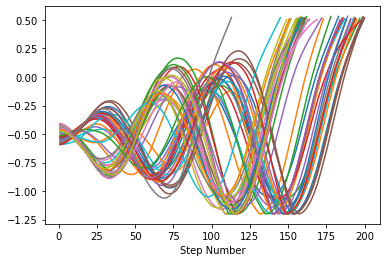

In [3]:
fig, ax = plt.subplots()

for episode in success_df.episode.sample(n=50).unique():
    success_df[success_df.episode == episode].plot.line(x='step', y='position', ax=ax)
ax.get_legend().remove()
ax.set_xlabel("Step Number")


Let's specifically plot some superlative episodes (first, best, worst)

2022-03-06 20:00:33 - INFO    -   MSDS-680 - Average steps of successful episodes: 168
2022-03-06 20:00:33 - INFO    -   MSDS-680 - Episode 1474 (first) successful on step 191
2022-03-06 20:00:33 - INFO    -   MSDS-680 - Episode 4822 (best) successful on step 111
2022-03-06 20:00:33 - INFO    -   MSDS-680 - Episode 1761 (worst) successful on step 200


(0.0, 200.0)

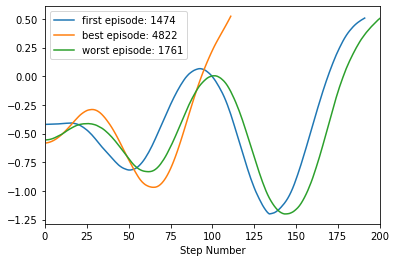

In [4]:
success_steps_df    = success_df[success_df.position >= 0.5]

LOGGER.info(f'Average steps of successful episodes: {int(success_steps_df.step.mean())}')

episode_superlatives = {
    'first': success_steps_df[success_steps_df.episode == success_steps_df.episode.min()].episode.values[0],
    'best': success_steps_df[success_steps_df.step == success_steps_df.step.min()].episode.values[0],
    'worst': success_steps_df[success_steps_df.step == success_steps_df.step.max()].episode.values[0],
}

fig, ax = plt.subplots()

for episode_name, episode_num in episode_superlatives.items():
    episode_df = success_df[success_df.episode == episode_num]
    episode_df.plot.line(x='step', y='position', ax=ax, label=f'{episode_name} episode: {episode_num}')
    LOGGER.info(f'Episode {episode_num} ({episode_name}) successful on step {episode_df.step.max()}')

ax.set_xlabel("Step Number")
ax.set_xlim((0, 200))


The tutorial (PythonProgramming.net, n.d.) plots a sample of the aggregated
reward for a set of episodes.  Since the default reward on each unsuccessful
step is `-1`, I believe the aggregate reward is a proxy for how quickly (in
terms of steps) the car achieves its goal (achieving the goal in fewer steps
results in a less negative aggregate reward).

Below, we graph the step on which the goal was acheived for all episodes (which,
again, equates to a less negative aggregate reward).  We can see that the
majority of episodes achieve success between 150-200 steps.  A much smaller
subset achieves success in less than 150 steps.

<AxesSubplot:xlabel='episode', ylabel='step'>

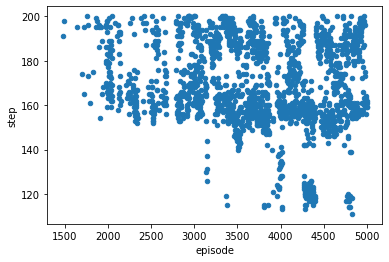

In [6]:
grouped_df = success_df.groupby(by='episode').step.max().reset_index()
grouped_df.plot.scatter(x='episode', y='step')


## 2.B Num episodes: 5000, Success Reward: Based on Steps

In this experiment, we base the success reward on how quickly the car achieves
the goal.  Since the episode will end at 200 steps if not successful, we
calculate the reward as $f(step) = 200 - step$.


In [7]:
metrics_df = pd.read_csv('mtn-car-data/mtn-car-5000-episodes-2022-03-06T00:21:48.csv', index_col=0)

success_episodes = metrics_df[metrics_df.position >= 0.5].episode.unique()
success_df = metrics_df[metrics_df.episode.isin(success_episodes)]
success_count = len(success_df.episode.unique())

LOGGER.info(f'Number of successful episodes: {success_count} ({success_count/5000:.2%})')

success_df.episode.describe()

2022-03-06 20:00:35 - INFO    -   MSDS-680 - Number of successful episodes: 2484 (49.68%)


count    407930.000000
mean       3637.015689
std         819.912034
min        1634.000000
25%        2992.000000
50%        3704.000000
75%        4331.000000
max        5000.000000
Name: episode, dtype: float64

Again, we can visualize the position and the velocity of the car
for (a sample of) successful episodes.  The plot below illustrates the position
of the car at each step, with steeper curves indicating higher velocity.

Text(0.5, 0, 'Step Number')

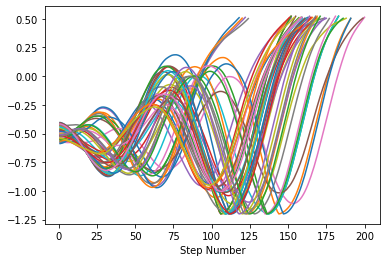

In [8]:
fig, ax = plt.subplots()

for episode in success_df.episode.sample(n=50).unique():
    success_df[success_df.episode == episode].plot.line(x='step', y='position', ax=ax)
ax.get_legend().remove()
ax.set_xlabel("Step Number")


Again, we specifically plot some superlative episodes (first, best, worst)

2022-03-06 20:02:10 - INFO    -   MSDS-680 - Average steps of successful episodes: 164
2022-03-06 20:02:11 - INFO    -   MSDS-680 - Episode 1634 (first) successful on step 175
2022-03-06 20:02:11 - INFO    -   MSDS-680 - Episode 3698 (best) successful on step 113
2022-03-06 20:02:11 - INFO    -   MSDS-680 - Episode 2016 (worst) successful on step 200


(0.0, 200.0)

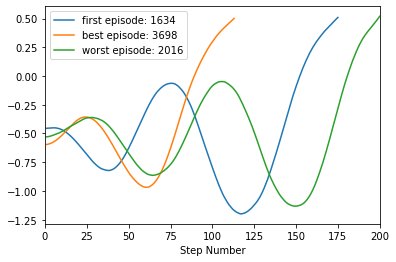

In [12]:
success_steps_df    = success_df[success_df.position >= 0.5]

LOGGER.info(f'Average steps of successful episodes: {int(success_steps_df.step.mean())}')

episode_superlatives = {
    'first': success_steps_df[success_steps_df.episode == success_steps_df.episode.min()].episode.values[0],
    'best': success_steps_df[success_steps_df.step == success_steps_df.step.min()].episode.values[0],
    'worst': success_steps_df[success_steps_df.step == success_steps_df.step.max()].episode.values[0],
}

fig, ax = plt.subplots()

for episode_name, episode_num in episode_superlatives.items():
    episode_df = success_df[success_df.episode == episode_num]
    episode_df.plot.line(x='step', y='position', ax=ax, label=f'{episode_name} episode: {episode_num}')
    LOGGER.info(f'Episode {episode_num} ({episode_name}) successful on step {episode_df.step.max()}')

ax.set_xlabel("Step Number")
ax.set_xlim((0, 200))



Again, we graph the step on which the goal was acheived for all episodes.
It appears that, even though the majority of episodes still achieve success
between 150-200 steps.  But, a larger subset (than the previous experiment)
achieves success in less than 150 steps.  Furthermore, it appears that more
episodes are centered around `~160` with relatively fewer near `200`.

<AxesSubplot:xlabel='episode', ylabel='step'>

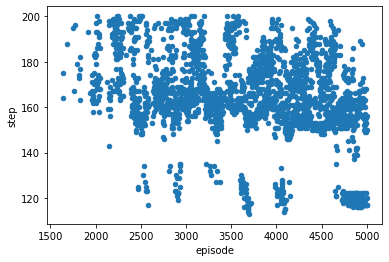

In [10]:
grouped_df = success_df.groupby(by='episode').step.max().reset_index()
grouped_df.plot.scatter(x='episode', y='step')


## 2.C Num episodes: 15000, Success Reward: Based on Steps

In this experiment, we continue to base the success reward on how quickly the
car achieves the goal.  We allow the simulation to run for `15,000` episodes.
This experiment achieves `~8400` successes with an average number of steps of
`145`!

In [13]:
metrics_df = pd.read_csv('mtn-car-data/mtn-car-15000-episodes-2022-03-06T18:56:25.csv', index_col=0)

success_episodes = metrics_df[metrics_df.position >= 0.5].episode.unique()
success_df = metrics_df[metrics_df.episode.isin(success_episodes)]
success_count = len(success_df.episode.unique())

LOGGER.info(f'Number of successful episodes: {success_count} ({success_count/15000:.2%})')

success_df.episode.describe()

2022-03-06 20:03:28 - INFO    -   MSDS-680 - Number of successful episodes: 8398 (55.99%)


count    1.224415e+06
mean     1.030330e+04
std      2.641748e+03
min      3.815000e+03
25%      8.127000e+03
50%      1.022200e+04
75%      1.254200e+04
max      1.500000e+04
Name: episode, dtype: float64

Again, we can visualize the position and the velocity of the car
for (a sample of) successful episodes.  The plot below illustrates the position
of the car at each step, with steeper curves indicating higher velocity.

Text(0.5, 0, 'Step Number')

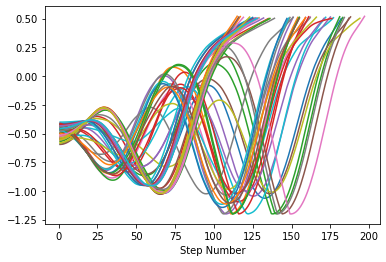

In [14]:
fig, ax = plt.subplots()

for episode in success_df.episode.sample(n=50).unique():
    success_df[success_df.episode == episode].plot.line(x='step', y='position', ax=ax)
ax.get_legend().remove()
ax.set_xlabel("Step Number")


Again, we specifically plot some superlative episodes (first, best, worst)

2022-03-06 20:05:31 - INFO    -   MSDS-680 - Average steps of successful episodes: 145
2022-03-06 20:05:31 - INFO    -   MSDS-680 - Episode 3815 (first) successful on step 200
2022-03-06 20:05:31 - INFO    -   MSDS-680 - Episode 11165 (best) successful on step 114
2022-03-06 20:05:31 - INFO    -   MSDS-680 - Episode 3815 (worst) successful on step 200


(0.0, 200.0)

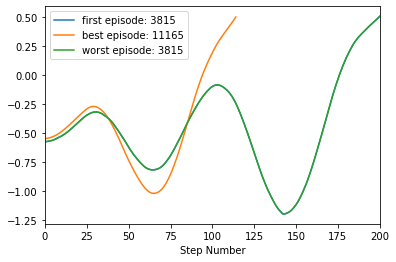

In [15]:
success_steps_df    = success_df[success_df.position >= 0.5]

LOGGER.info(f'Average steps of successful episodes: {int(success_steps_df.step.mean())}')

episode_superlatives = {
    'first': success_steps_df[success_steps_df.episode == success_steps_df.episode.min()].episode.values[0],
    'best': success_steps_df[success_steps_df.step == success_steps_df.step.min()].episode.values[0],
    'worst': success_steps_df[success_steps_df.step == success_steps_df.step.max()].episode.values[0],
}

fig, ax = plt.subplots()

for episode_name, episode_num in episode_superlatives.items():
    episode_df = success_df[success_df.episode == episode_num]
    episode_df.plot.line(x='step', y='position', ax=ax, label=f'{episode_name} episode: {episode_num}')
    LOGGER.info(f'Episode {episode_num} ({episode_name}) successful on step {episode_df.step.max()}')

ax.set_xlabel("Step Number")
ax.set_xlim((0, 200))



Again, we graph the step on which the goal was acheived for all episodes.
This plot has a very interesting gap in the successful step number appearing
at episode `~11000`!  It appears that after this point, an episode is either
going to be successful *relatively quickly* or *relatively late* in the episode!

This may be related to exploration vs exploitation.  Once the model is
well-trained, exploitation should generally be successful.  Occasional
experimentation may result in taking longer but overall won't lead to failure.

A future experiment could involve a) repeating this phenomenon and b) recording
epsilon at each episode.

<AxesSubplot:xlabel='episode', ylabel='step'>

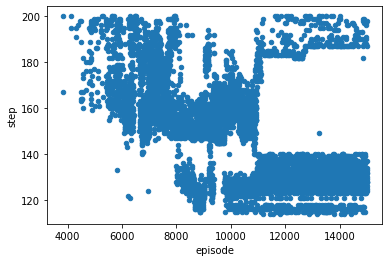

In [16]:
grouped_df = success_df.groupby(by='episode').step.max().reset_index()
grouped_df.plot.scatter(x='episode', y='step')


# References

GitHub.com (n.d.).  *OpenAI/Gym*.  Retrieved from
https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

Hayes, G. (2019, February).  *Getting Started with Reinforcement Learning and
Open AI Gym*.  Retrieved from https://towardsdatascience.com/getting-started-with-reinforcement-learning-and-open-ai-gym-c289aca874f

PythonProgramming.net (n.d).  *Q-Learning introduction and Q Table -
Reinforcement Learning w/ Python Tutorial p.1*.  Retrieved from 
https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
